In [26]:
import cv2
import imghdr
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

# Data directory

In [42]:
data_dir = ".\photos"
formats = ['jpeg','jpg', 'bmp', 'png','webp']
class_list=os.listdir(".\photos")
print(class_list)

['Ford', 'Honday', 'Hyundai', 'Nissan', 'Renault', 'Suzuki', 'Tata', 'Toyota', 'Volkswagen']


# Check valid file format and remove invalid images

In [43]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            img_type = imghdr.what(image_path)
            if img_type not in formats: 
                os.remove(image_path)
                print('Invalid format, deleting... {} '.format(image_path))
        except Exception as e: 
            os.remove(image_path)
            print('Unable to read, deleting... {} '.format(image_path))

Invalid format, deleting... .\photos\Hyundai\frontfacingHyundaicar327.gif 
Invalid format, deleting... .\photos\Hyundai\frontfacingHyundaicar339.gif 
Invalid format, deleting... .\photos\Hyundai\frontfacingHyundaicar362.gif 
Invalid format, deleting... .\photos\Nissan\frontfacingNissancar123.gif 
Invalid format, deleting... .\photos\Nissan\frontfacingNissancar303.jpeg 
Invalid format, deleting... .\photos\Nissan\frontfacingNissancar463.gif 
Invalid format, deleting... .\photos\Nissan\frontfacingNissancar503.gif 
Invalid format, deleting... .\photos\Renault\frontfacingRenaultcar458.gif 
Invalid format, deleting... .\photos\Suzuki\frontfacingsuzukicar527.gif 
Invalid format, deleting... .\photos\Tata\frontfacingTatamotorscar407.gif 
Invalid format, deleting... .\photos\Toyota\frontfacingToyotacar359.gif 


# Visualise number of images in each dataset

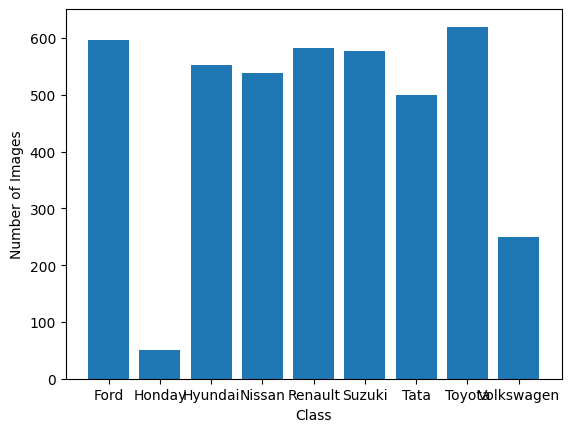

In [44]:
import os
import matplotlib.pyplot as plt

photos_dir = 'photos'
class_dirs = os.listdir(photos_dir)
num_images = []

for class_dir in class_dirs:
    class_path = os.path.join(photos_dir, class_dir)
    num_images.append(len(os.listdir(class_path)))

plt.bar(class_dirs, num_images)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


We can notice that Honda and Volkswagen datasets are small comparet to others. We will need to apply data  augmentation to balance out the dataset in future code.

# Use YOLOv3 Pre-trained object detection model to:
# 1. Detect car.
# 2. If car detected, crop out the extra area and save just the car as image.
# 3. If not, remove the image.
This dataset contains many images that are not of cars.
We shall use some pre trained object detection model like YOLO, Haar Cascade or Caffe Model to remove those images that are not of cars.

In [45]:
import os
import cv2
import numpy as np


#-------------------------------------------------------------------------------------------------


def is_usable(image_path):
    return os.path.isfile(image_path)


#-------------------------------------------------------------------------------------------------


def detect_cars(img):                                                                            
    # Load the pre-trained YOLO model                                                       
    net = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")

    # Define the list of class labels for YOLO
    class_labels = ["car"]

    # Get the output layer names of the network
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Preprocess the image
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Pass the image through the network
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)

    # Process the layer outputs to detect cars
    boxes = []
    confidences = []
    class_ids = []
    (H, W) = img.shape[:2]

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id == 2 and confidence > 0.3:  # Only detect cars with confidence higher than 0.3
                box = detection[0:4] * np.array([W, H, W, H])
                (center_x, center_y, width, height) = box.astype("int")

                x = int(center_x - (width / 2))
                y = int(center_y - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    # Crop the detected car areas
    car_images = []
    for i in indices:
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        if w > 0 and h > 0:
            car_image = img[y:y+h, x:x+w]
            if not car_image.size == 0:
                car_image = cv2.resize(img[y:y+h, x:x+w], (400, 400))
                car_images.append(car_image)

    return car_images
#---------------------------------------------------------------------------------------------------------


photos_dir = 'photos'
for class_dir in os.listdir(photos_dir):
    class_path = os.path.join(photos_dir, class_dir)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        if is_usable(image_path):
            try:
                img = cv2.imread(image_path)
                car_images = detect_cars(img)
                if car_images and car_images[0] is not None:
                    try:
                        cv2.imwrite(image_path, car_images[0])
                    except cv2.error as e:
                        print(f"Error saving image: {image_path}")
                        print(e)
                else:
                    os.remove(image_path)
            except Exception as e:
                print(f"Error processing image: {image_path}")
                print(e)


Error saving image: photos\Hyundai\frontfacingHyundaicar208.mpo
OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:696: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

Error saving image: photos\Volkswagen\frontfacingVolkswagen46.mpo
OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:696: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

Error saving image: photos\Volkswagen\frontfacingVolkswagen47.mpo
OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:696: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'



# Manual inspection and removal of leftover useless images.
At this point, most images have been filtered out correctly and only a few bad samples are left. 
We shall proceed to manually remove these from the dataset by manual inspection.


Visualisation of final dataset 

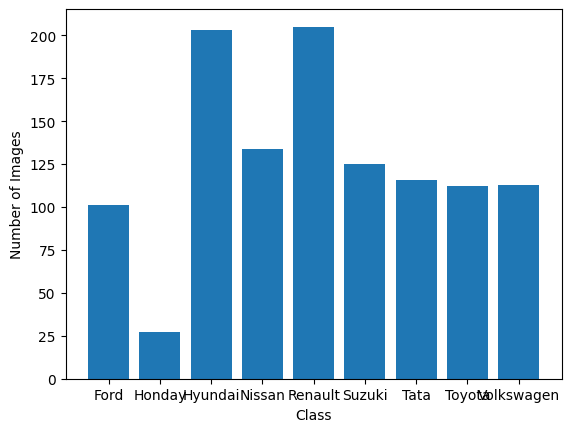

In [47]:
import os
import matplotlib.pyplot as plt

photos_dir = 'photos'
class_dirs = os.listdir(photos_dir)
num_images = []

for class_dir in class_dirs:
    class_path = os.path.join(photos_dir, class_dir)
    num_images.append(len(os.listdir(class_path)))

plt.bar(class_dirs, num_images)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


As the above graph shows, the dataset is very imbalanced.
We shall apply data augmentation to increase and balance out the dataset size.

# Apply Sharpening to finalized images where needed.

In [48]:
import os
import cv2
import numpy as np

def is_sharp(img, threshold=100):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the Laplacian of the image and then the variance
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()

    # If the variance is below the threshold, the image is considered not sharp
    return variance > threshold

def sharpen(img):
    # Create a sharpening kernel
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

    # Apply the sharpening kernel to the image
    sharpened = cv2.filter2D(img, -1, kernel)

    return sharpened

photos_dir = 'photos'
for class_dir in os.listdir(photos_dir):
    class_path = os.path.join(photos_dir, class_dir)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        try:
            img = cv2.imread(image_path)
            if not is_sharp(img):
                img = sharpen(img)
                cv2.imwrite(image_path, img)
        except Exception as e:
            print(f"Error processing image: {image_path}")
            print(e)


# Check the dataset for valid car images
Define 'is_usable' function to check if the current car image is usable or not, it checks if there is a valid car in the image by calling the 'detect_car' function defined above.

This code iterates through all folders in the main directory and removes the unusable images. Since this dataset is very low quality and there are many useless side facing cars, this model might not be able to detect all of them as it is primarily meant to detect cars and not just front facing cars.

Check how many files are now present after the model is used

In [56]:
data = tf.keras.utils.image_dataset_from_directory(".\photos")

Found 4592 files belonging to 9 classes.


# Pick random sample to check accuracy of remaining images

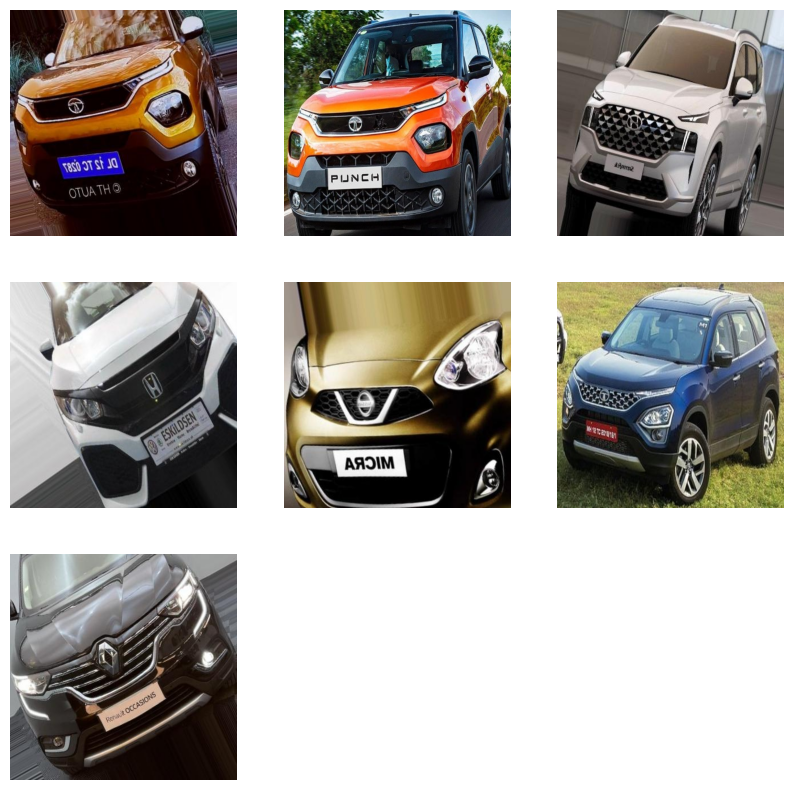

In [59]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def get_random_images(photos_dir, num_images):
    # Get the list of all image paths
    image_paths = []
    for class_dir in os.listdir(photos_dir):
        class_path = os.path.join(photos_dir, class_dir)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)

    # Pick num_images random images from the list
    random_images = random.sample(image_paths, num_images)

    return random_images

def display_images(image_paths):
    # Create a figure to display the images
    fig = plt.figure(figsize=(10, 10))

    # Display each image
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        ax = fig.add_subplot(3, 3, i + 1)
        ax.imshow(img)
        ax.axis('off')

    # Show the figure
    plt.show()

photos_dir = './photos'
num_images = 7
random_images = get_random_images(photos_dir, num_images)
display_images(random_images)

# Apply data augmentation to classes which have very less images

In [54]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

def augment_images(image_path, save_dir, n_augmentations=10):
    # Load the image
    img = cv2.imread(image_path)

    # Create an ImageDataGenerator with various data augmentation options
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Reshape the image to rank 4
    img = img.reshape((1,) + img.shape)

    # Generate augmented images and save them to the specified directory
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= n_augmentations:
            break

max_images_per_class = 450
photos_dir = 'photos'
for class_dir in os.listdir(photos_dir):
    class_path = os.path.join(photos_dir, class_dir)
    image_names = os.listdir(class_path)
    n_images = len(image_names)
    if n_images < max_images_per_class:
        n_augmentations_per_image = min((max_images_per_class - n_images) // n_images + 1, max_images_per_class - n_images)
        for image_name in image_names:
            image_path = os.path.join(class_path, image_name)
            try:
                augment_images(image_path, class_path, n_augmentations_per_image)
            except Exception as e:
                print(f"Error processing image: {image_path}")
                print(e)


# Final visualization of dataset size (after augmentation)

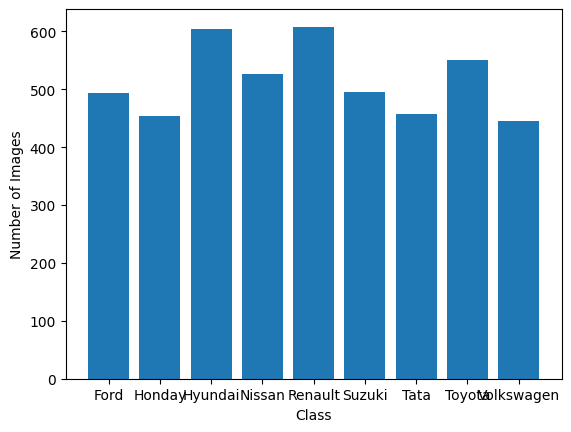

In [55]:
import os
import matplotlib.pyplot as plt

photos_dir = 'photos'
class_dirs = os.listdir(photos_dir)
num_images = []

for class_dir in class_dirs:
    class_path = os.path.join(photos_dir, class_dir)
    num_images.append(len(os.listdir(class_path)))

plt.bar(class_dirs, num_images)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


As can be seen in the graph, augmentation has helped increase the dataset size and balance out the various classes' datasets. 

# Problems faced during preprocessing 

1. Too many car images were not front-facing, or had unrecognizable or blurred logos.
2. After researching extensively I could not come up with a pre-trained model or method to identify only front facing images, so I had to manually delete those images.
3. Also, many images were in wrong classes, for example there were Honda cars in Nissan and so on.
4. Another problem I faced was the long time taken by the code to iterate throught the whole dataset, owing to the deletion and saving operations. So I had to leave the process running for a few hours.
5. Initially, the .mpo type files caused the loops to stop as they were unreadable. I had to include a try-catch block to handle the errors. 